In [2]:
from torch import nn

In [3]:
class WeightEMA (object):
    """
    Exponential moving average weight optimizer for mean teacher model

    Taken from https://github.com/Britefury/self-ensemble-visual-domain-adapt
    """
    def __init__(self, params, src_params, alpha=0.999):

        # super(WeightEMA, self).__init__(params, {})

        self.params = list(params)
        self.src_params = list(src_params)
        self.alpha = alpha

        for p, src_p in zip(self.params, self.src_params):
            p.data[:] = src_p.data[:]

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for p, src_p in zip(self.params, self.src_params):
            p.data.mul_(self.alpha)
            p.data.add_(src_p.data * one_minus_alpha)

    def zero_grad(self):
        pass

In [58]:
class WeightedCE(nn.Module):
    
    def __init__(self):
        
        super(WeightedCE, self).__init__()
        
        self.threshold =  0.5
        self.softmax  = nn.Softmax(dim=-1)
        self.ce       = nn.CrossEntropyLoss() #reduce=False)
        
    def forward(self, logits, logits_target):
        
        p       = self.softmax(logits_target).detach()
        targets = logits_target.max(dim=-1)[1].detach()
        
        tt = targets.unsqueeze(-1).expand_as(p)
        
        p = p.gather(dim=-1, index=tt)[:,0]
        mask    = (p > self.threshold).detach()
        
        if mask.sum() > 0:
            return self.ce(logits[mask], targets[mask])
        
        return 0
    
y = torch.randn(10,3)
t = torch.randn(10,3)

loss = WeightedCE()

loss(y,t)

tensor(1.4044)

In [9]:
from salad import datasets

import torch

data = datasets.load_dataset(path="/tmp/data", train=True)

train_loader = torch.utils.data.DataLoader(
    data['svhn'], batch_size=64,
    shuffle=True)
val_loader   = torch.utils.data.DataLoader(
    data['mnist'], batch_size=64,
    shuffle=True)

loader = datasets.JointLoader(train_loader, val_loader)

Using downloaded and verified file: /tmp/data/train_32x32.mat


In [23]:
from salad.models import ConditionalModel

from augment import AffineTransformer

augment = AffineTransformer()

for (x,y), _ in loader:
    
    x = augment(x)
    
    print(x.size())
    
    break

torch.Size([64, 3, 32, 32])


In [140]:
class WeightedCE(nn.Module):
    
    def __init__(self):
        
        super(WeightedCE, self).__init__()
        
        self.threshold =  0.96
        self.softmax   = nn.Softmax(dim=-1)
        self.mse        = nn.MSELoss()
        
    def forward(self, logits, logits_target):
        
        p          = self.softmax(logits_target)
        conf, lbl  = p.max(dim=-1)
        mask       = (conf > self.threshold)
        
        if mask.sum() > 0:
            loss = self.mse(logits[mask], logits_target[mask]) 
            return loss
        
        return 0 * self.mse(logits[:1], logits_target[:1])
    
loss = WeightedCE()

logits        = torch.randn(100,10)
logits_target = torch.randn(100,10)

logits_target[:,9] *= logits_target[:,9]
logits_target[:,9] *= 1000

print(logits.new_zeros(1))

#logits_target.data[:] = logits.data[:]

loss(logits, logits_target)

tensor([ 0.])


tensor(3.4594e+05)

In [142]:
torch.randn_like(logits.cuda())

tensor([[ 0.3916,  0.6465,  0.1159,  0.8023, -1.0251,  0.2096, -1.3726,
          0.6628, -0.7588, -0.9605],
        [-0.4376,  1.6126,  1.8585,  0.5551, -0.3159, -0.0702, -0.1690,
          0.3227, -0.7297, -0.8696],
        [-1.1720, -0.6849, -1.3117,  0.8436, -0.2216,  1.6202, -0.7229,
         -0.4423, -0.3916, -1.1223],
        [-1.2064, -0.1910,  0.4501,  0.1902, -0.7784,  0.2243, -0.0480,
         -0.5749, -0.8056, -0.1981],
        [ 0.1557, -0.2167, -0.7670,  0.2502,  0.0028, -0.3312, -0.1706,
          0.3629, -0.2987,  2.0248],
        [ 0.8275, -2.0902, -0.1750, -0.4285, -0.5945,  2.7266, -1.8903,
          0.0660,  0.0052, -1.4676],
        [-0.0691,  0.3711, -0.3798, -0.7938,  0.6455,  0.5704, -0.1177,
          0.4658, -0.0555,  1.3204],
        [ 2.0442,  0.5023, -0.0030,  0.8134, -1.2520, -0.0956, -0.3707,
          0.3375, -0.4868,  0.6428],
        [ 0.6002, -0.8822, -1.0203, -0.8773,  1.2833,  0.6801,  0.5942,
          0.2828,  1.3292,  0.3063],
        [ 1.1577,  

In [121]:
from train_ensemble import AffineTransformer
from salad.utils import panelize
import matplotlib.pyplot as plt

from salad import datasets
from torch.utils.data import DataLoader

data = datasets.load_dataset(path="data", train=True)

loader = DataLoader(data['svhn'], batch_size=32, shuffle=True)

Using downloaded and verified file: data/train_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


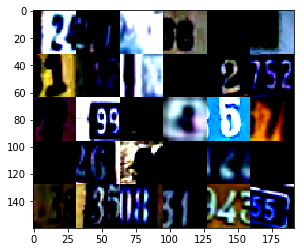

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


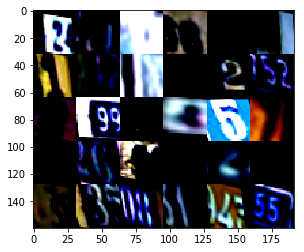

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


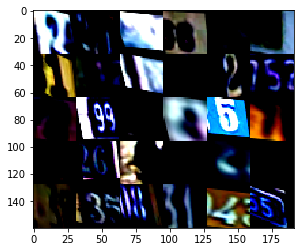

In [135]:
augment = AffineTransformer(
                 flip_x  = 0,
                 flip_y  = 0,
                 shear_x = (0,0.3),
                 shear_y = (0,0.3),
                 scale   = (0.8,1.4),
                 rotate  = (-.1,.1),
                 dx      = (-.2,.2),
                 dy      = (-.2,.2)
)

for x, y in loader:
    
    plt.imshow(panelize(x.numpy()))
    plt.show()
    
    plt.imshow(panelize(augment(x).numpy()))
    plt.show()
    
    plt.imshow(panelize(augment(x).numpy()))
    plt.show()
    
    break

In [144]:
import numpy as np
import cv2

def identity_xf(N):
    """
    Construct N identity 2x3 transformation matrices
    :return: array of shape (N, 2, 3)
    """
    xf = np.zeros((N, 2, 3), dtype=np.float32)
    xf[:, 0, 0] = xf[:, 1, 1] = 1.0
    return xf

def inv_nx2x2(X):
    """
    Invert the N 2x2 transformation matrices stored in X; a (N,2,2) array
    :param X: transformation matrices to invert, (N,2,2) array
    :return: inverse of X
    """
    rdet = 1.0 / (X[:, 0, 0] * X[:, 1, 1] - X[:, 1, 0] * X[:, 0, 1])
    y = np.zeros_like(X)
    y[:, 0, 0] = X[:, 1, 1] * rdet
    y[:, 1, 1] = X[:, 0, 0] * rdet
    y[:, 0, 1] = -X[:, 0, 1] * rdet
    y[:, 1, 0] = -X[:, 1, 0] * rdet
    return y

def inv_nx2x3(m):
    """
    Invert the N 2x3 transformation matrices stored in X; a (N,2,3) array
    :param X: transformation matrices to invert, (N,2,3) array
    :return: inverse of X
    """
    m2 = m[:, :, :2]
    mx = m[:, :, 2:3]
    m2inv = inv_nx2x2(m2)
    mxinv = np.matmul(m2inv, -mx)
    return np.append(m2inv, mxinv, axis=2)

def cat_nx2x3(a, b):
    """
    Multiply the N 2x3 transformations stored in `a` with those in `b`
    :param a: transformation matrices, (N,2,3) array
    :param b: transformation matrices, (N,2,3) array
    :return: `a . b`
    """
    a2 = a[:, :, :2]
    b2 = b[:, :, :2]

    ax = a[:, :, 2:3]
    bx = b[:, :, 2:3]

    ab2 = np.matmul(a2, b2)
    abx = ax + np.matmul(a2, bx)
    return np.append(ab2, abx, axis=2)

def rotation_matrices(thetas):
    """
    Generate rotation matrices
    :param thetas: rotation angles in radians as a (N,) array
    :return: rotation matrices, (N,2,3) array
    """
    N = thetas.shape[0]
    rot_xf = np.zeros((N, 2, 3), dtype=np.float32)
    rot_xf[:, 0, 0] = rot_xf[:, 1, 1] = np.cos(thetas)
    rot_xf[:, 1, 0] = np.sin(thetas)
    rot_xf[:, 0, 1] = -np.sin(thetas)
    return rot_xf

def centre_xf(xf, size):
    """
    Centre the transformations in `xf` around (0,0), where the current centre is assumed to be at the
    centre of an image of shape `size`
    :param xf: transformation matrices, (N,2,3) array
    :param size: image size
    :return: centred transformation matrices, (N,2,3) array
    """
    height, width = size

    # centre_to_zero moves the centre of the image to (0,0)
    centre_to_zero = np.zeros((1, 2, 3), dtype=np.float32)
    centre_to_zero[0, 0, 0] = centre_to_zero[0, 1, 1] = 1.0
    centre_to_zero[0, 0, 2] = -float(width) * 0.5
    centre_to_zero[0, 1, 2] = -float(height) * 0.5

    # centre_to_zero then xf
    xf_centred = cat_nx2x3(xf, centre_to_zero)

    # move (0,0) back to the centre
    xf_centred[:, 0, 2] += float(width) * 0.5
    xf_centred[:, 1, 2] += float(height) * 0.5

    return xf_centred


class ImageAugmentation (object):
    def __init__(self, hflip, xlat_range, affine_std, rot_std=0.0,
                 intens_flip=False,
                 intens_scale_range_lower=None, intens_scale_range_upper=None,
                 intens_offset_range_lower=None, intens_offset_range_upper=None,
                 scale_x_range=None, scale_y_range=None, scale_u_range=None, gaussian_noise_std=0.0,
                 blur_range=None):
        self.hflip = hflip
        self.xlat_range = xlat_range
        self.affine_std = affine_std
        self.rot_std = rot_std
        self.intens_scale_range_lower = intens_scale_range_lower
        self.intens_scale_range_upper = intens_scale_range_upper
        self.intens_offset_range_lower = intens_offset_range_lower
        self.intens_offset_range_upper = intens_offset_range_upper
        self.intens_flip = intens_flip
        self.scale_x_range = scale_x_range
        self.scale_y_range = scale_y_range
        self.scale_u_range = scale_u_range
        self.gaussian_noise_std = gaussian_noise_std
        self.blur_range = blur_range


    def augment(self, X):
        X = X.copy()
        xf = identity_xf(len(X))

        if self.hflip:
            x_hflip = np.random.binomial(1, 0.5, size=(len(X),)) * 2 - 1
            xf[:, 0, 0] = x_hflip

        if self.scale_x_range is not None and self.scale_x_range[0] is not None:
            xf[:, 0, 0] *= np.random.uniform(low=self.scale_x_range[0], high=self.scale_x_range[1], size=(len(X),))
        if self.scale_y_range is not None and self.scale_y_range[0] is not None:
            xf[:, 1, 1] *= np.random.uniform(low=self.scale_y_range[0], high=self.scale_y_range[1], size=(len(X),))
        if self.scale_u_range is not None and self.scale_u_range[0] is not None:
            scale_u = np.random.uniform(low=self.scale_u_range[0], high=self.scale_u_range[1], size=(len(X),))
            xf[:, 0, 0] *= scale_u
            xf[:, 1, 1] *= scale_u

        if self.affine_std > 0.0:
            xf[:, :, :2] += np.random.normal(scale=self.affine_std, size=(len(X), 2, 2))

        if self.rot_std > 0.0:
            thetas = np.random.normal(scale=self.rot_std, size=(len(X),))
            rot_xf = rotation_matrices(thetas)
            xf = cat_nx2x3(xf, rot_xf)

        if self.xlat_range > 0.0:
            xf[:, :, 2:] += np.random.uniform(low=-self.xlat_range, high=self.xlat_range, size=(len(X), 2, 1))

        if self.intens_flip:
            col_factor = (np.random.binomial(1, 0.5, size=(len(X), 1, 1, 1)) * 2 - 1).astype(np.float32)
            X = (X * col_factor).astype(np.float32)

        if self.intens_scale_range_lower is not None:
            col_factor = np.random.uniform(low=self.intens_scale_range_lower, high=self.intens_scale_range_upper,
                                           size=(len(X), 1, 1, 1))

            X = (X * col_factor).astype(np.float32)

        if self.intens_offset_range_lower is not None:
            col_offset = np.random.uniform(low=self.intens_offset_range_lower, high=self.intens_offset_range_upper,
                                           size=(len(X), 1, 1, 1))

            X = (X + col_offset).astype(np.float32)

        xf_centred = centre_xf(xf, X.shape[2:])
        for i in range(len(X)):
            if X.shape[1] == 1:
                X[i, 0, :, :] = cv2.warpAffine(X[i, 0, :, :], xf_centred[i, :, :], (X.shape[3], X.shape[2]))
            else:
                X[i, :, :, :] = cv2.warpAffine(X[i, :, :, :].transpose(1,2,0), xf_centred[i, :, :], (X.shape[3], X.shape[2])).transpose(2,0,1)

        if self.blur_range is not None and self.blur_range[0] is not None:
            sigmas = np.random.uniform(low=self.blur_range[0], high=self.blur_range[1], size=(len(X),))
            sigmas = np.maximum(sigmas, 0.0)
            for i in range(len(X)):
                sigma = sigmas[i]
                # ksize must be odd number
                ksize = int(sigma+0.5) * 8 + 1
                if X.shape[1] == 1:
                    X[i, 0, :, :] = cv2.GaussianBlur(X[i, 0, :, :], (ksize, ksize), sigmaX=sigma)
                else:
                    X[i, :, :, :] = cv2.GaussianBlur(X[i, :, :, :].transpose(1,2,0), (ksize, ksize), sigmaX=sigma).transpose(2,0,1)

        if self.gaussian_noise_std > 0.0:
            X += np.random.normal(scale=self.gaussian_noise_std, size=X.shape).astype(np.float32)

        return X


    def augment_pair(self, X):
        return self.augment(X), self.augment(X)

In [154]:
x.new_tensor([1,2,3])

tensor([ 1.,  2.,  3.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


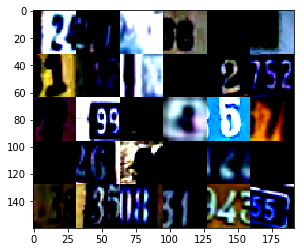

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


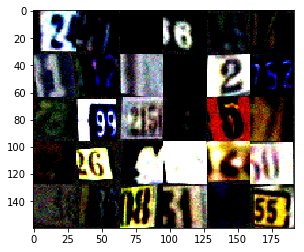

In [153]:
augment = ImageAugmentation(
    affine_std=0.1,
    gaussian_noise_std=0.1,
    hflip=False,
    intens_flip=True,
    intens_offset_range_lower=-.5, intens_offset_range_upper=.5,
    intens_scale_range_lower=0.25, intens_scale_range_upper=1.5,
    xlat_range=2.0
)

plt.imshow(panelize(x.numpy()))
plt.show()
plt.imshow(panelize(augment.augment(x.numpy())))
plt.show()

Is the brain invariant to various changes in the world?
One crucial observation is that invariance and equivariance is *context dependent*:
It is based on the task I am aiming at solving that determines what level of invariance is appropriate.

The distinction between the important and unimportant aspects of a task crucially depends upon itself.

Stricingly, the brain is appearantly both prone and invariant to various sorts of domain shift:
- In the visual world, we exhibit a great deal of invarinaces against illumination, artificially introduced noise and other kinds.
- In sensorimotor experiments, models for generalization capabilities show that ...